In [14]:
import os
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import numpy as np

In [15]:
WD = '/local/meliao/projects/fourier_neural_operator/experiments/07_long_time_dependent_runs/'
os.chdir(WD)
print(os.getcwd())

/local/meliao/projects/fourier_neural_operator/experiments/07_long_time_dependent_runs


In [16]:
from train_models_baseline import SpectralConv1d, FNO1dComplex


In [17]:
BASELINE_MODEL = '/local/meliao/projects/fourier_neural_operator/experiments/07_long_time_dependent_runs/models/01_baseline_ep_1000'
TEST_DATA_FP = '/local/meliao/projects/fourier_neural_operator/data/2021-06-24_NLS_data_04_test.mat'

In [23]:
model = torch.load(BASELINE_MODEL, map_location='cpu')
d = sio.loadmat(TEST_DATA_FP)
X = d['output']
t = d['t']
x_grid = d['x']

In [45]:
def make_composed_predictions(X, t_interval, emulator):
    n_tsteps = X.shape[1]
    t_tensor = torch.tensor(t_interval, dtype=torch.float).repeat([X.shape[0], 1,1])
    preds = np.zeros(X.shape, dtype=np.cfloat)

    # The IC is at time 0
    preds[:,0] = X[:,0]

    comp_input_i = make_x_train(X[:,0])
    for i in range(1, n_tsteps):
        comp_preds_i = emulator(comp_input_i).detach().numpy()
        preds[:,i] = comp_preds_i
        comp_input_i = make_x_train(comp_preds_i)
    return preds

def make_x_train(X, single_batch=False):
    # X has shape (nbatch, 1, grid_size)
    n_batches = X.shape[0] if len(X.shape) > 1 else 1

    # Convert to tensor
    X_input = torch.view_as_real(torch.tensor(X, dtype=torch.cfloat))
    x_grid = torch.tensor(np.linspace(-np.pi, np.pi, 1024), dtype=torch.float).view(-1, 1)


    if single_batch:
        X_input = torch.cat((X_input, x_grid), dim=1)
    else:
        x_grid_i = x_grid.repeat((n_batches, 1, 1))
        X_input = torch.cat((X_input, x_grid_i), axis=2)

    return X_input

In [55]:
bad_input = X[59].reshape((1,21,1024))
print(bad_input.shape)
bad_preds = make_composed_predictions(bad_input, 1., model)
print(bad_preds.shape)

(1, 21, 1024)
(1, 21, 1024)


In [57]:
preds = make_composed_predictions(X, 1., model)

In [58]:
print(preds.shape)

(100, 21, 1024)


In [62]:
nrms = np.linalg.norm(preds, axis=-1)
print(nrms.shape)
print(nrms[:,0])
print(nrms[:,-1])

(100, 21)
[22.57946544 18.59608274 20.24159195 28.0591942  21.83848448 24.3891531
 22.39767868 20.80312945 15.02403779 23.14471265 23.62076991 22.939313
 23.00259425 21.14587138 23.45166435 20.54215103 21.47356397 19.49431218
 22.42902281 21.85714534 19.73284874 22.24342743 16.65626364 21.1747306
 20.81632728 22.71355923 19.3906636  23.47723938 24.83302345 23.59048244
 21.79558944 23.20601921 21.1478737  18.95459466 20.86234127 20.60797038
 24.8651655  27.67488026 26.31729111 23.55412318 20.74857558 24.33429108
 24.55683875 26.18317076 18.86627266 20.78626349 20.57508947 22.54201862
 22.06883644 21.75707038 19.43366346 20.17500299 21.81145647 17.41559787
 26.08539667 17.04394347 20.43821813 18.25625919 20.46715383 30.01861638
 22.27400422 23.86528779 24.90546027 24.88152057 20.38099254 25.24010521
 25.56037944 20.66607537 21.09926144 21.69493514 23.08246775 21.22719763
 23.69054761 20.30265587 21.14646832 22.78179694 19.3426583  20.38459296
 24.47988612 23.87738887 24.0523842  20.12338

In [53]:
def plot_one_testcase_panels(baseline_preds, solns, fp=None):
    SHOW_T_TIMESTEPS = 20
    ALPHA = 0.7 # Controls saturation of overlapping lines. 1 is full saturation, 0 is none.
    # preds has shape (n_tsteps, grid_size)
    # _, grid_size = baseline_preds.shape
    n_tsteps = SHOW_T_TIMESTEPS

    fig, ax = plt.subplots(n_tsteps, 3, sharex='col', sharey=False)
    fig.set_size_inches(15,20) #15, 20 works well
    ax[0,0].set_title("$Re(u)$", size=20)
    ax[0,1].set_title("$Im(u)$", size=20)
    ax[0,2].set_title("$| u - \\hat u|$", size=20)

    for i in range(n_tsteps):
        # First column has Re(prediction), Re(solution)
        ax[i,0].plot(np.real(solns[i+1]), alpha=ALPHA, label='solutions')
        ax[i,0].plot(np.real(baseline_preds[i]), '--', alpha=ALPHA, label='FNO Baseline preds')
        ax[i,0].set_ylabel("t = {}".format(i+1), size=15)

        # Second column has Im(prediction), Im(solution)
        ax[i,1].plot(np.imag(solns[i+1]), alpha=ALPHA, label='solutions')
        ax[i,1].plot(np.imag(baseline_preds[i]), '--', alpha=ALPHA, label='FNO Baseline preds')

        # Third column is Abs(prediction - solution)
        b_errors_i = np.abs(baseline_preds[i] - solns[i+1])
        ax[i,2].plot(b_errors_i, label='FNO baseline errors', color='green')
        ax[i,2].hlines(0, xmin=0, xmax=len(b_errors_i)-1, linestyles='dashed')

    ax[0,0].legend(fontsize=13, markerscale=2)
    ax[0,1].legend(fontsize=13, markerscale=2)
    ax[0,2].legend(fontsize=13, markerscale=2)
    if fp is not None:
        plt.savefig(fp)
    else:
        plt.show()
    plt.close(fig)

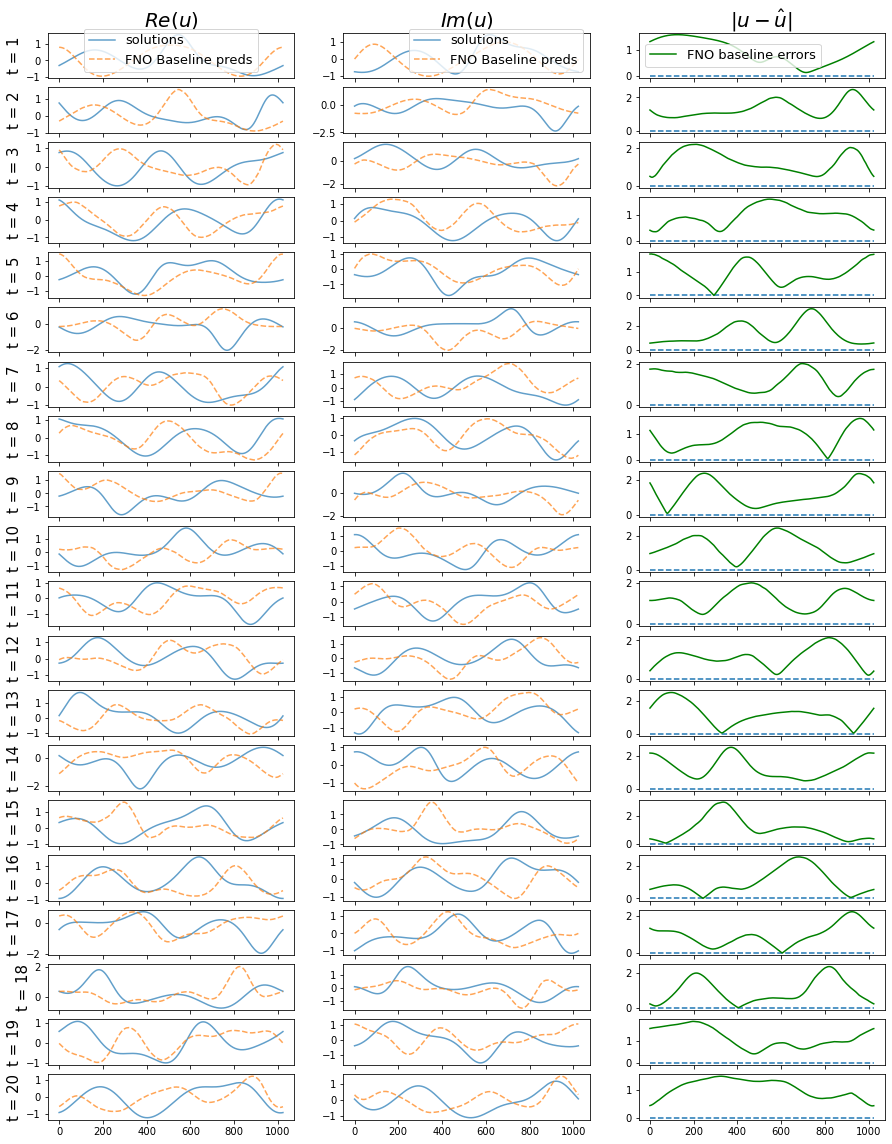

In [56]:
plot_one_testcase_panels(bad_preds[0], bad_input[0])